In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

In [2]:
import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score

from imblearn.metrics import geometric_mean_score

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Basic preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dialect/IADD.csv')

In [4]:
df

,Sentence,Region,DataSource,Country
0,: وش فيك تسألني إذا كنت غالي؟ غالي وتسوى من ...,GLF,DART,NaN
1,روان بن حسين مستحيل ما ادز شي بسناب حتى لو ما...,GLF,DART,NaN
2,: ما نسيتك بالدعا والأرض جفاف، وشلون أبنساك و...,GLF,DART,NaN
3,: فارس_البقميk_محب أطيب من الطيب واصل الطيب ...,GLF,DART,NaN
4,شوفو والله ابوها كشخه وصغير احس واضحه الفلوس م...,GLF,DART,NaN
...,...,...,...,...
135799,وترا الناس تغيرت ولايهم نظرة المجتمع مادام الو...,general,AOC,NaN
135800,متأثر ياربيع بالكرتون,general,AOC,NaN
135801,مبروك للاتحاد والاهلي وهاردلك للباقين,general,AOC,NaN
135802,هههههههوووووووووووووووووووووووهههههااااااااااا...,general,AOC,NaN


In [5]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 56.8 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)

Report initial_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



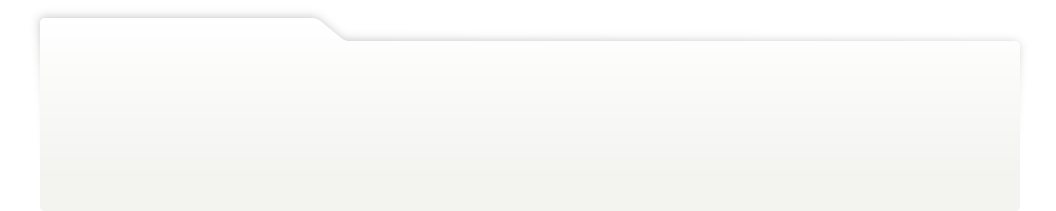
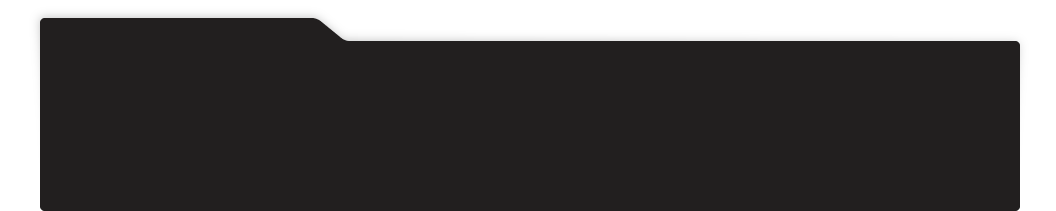
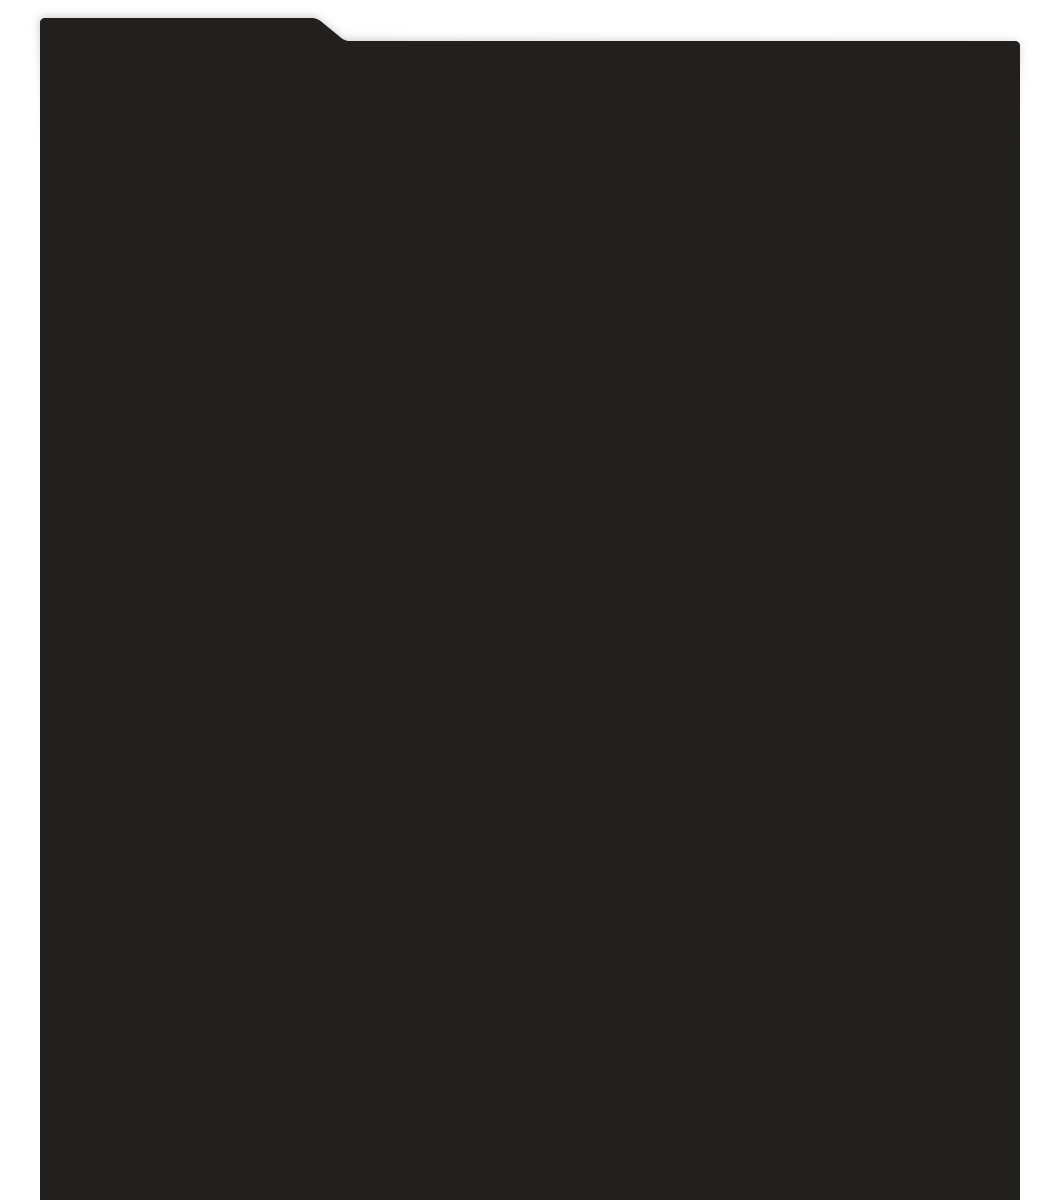
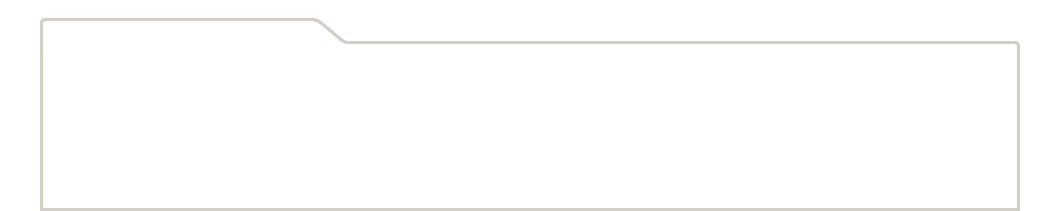
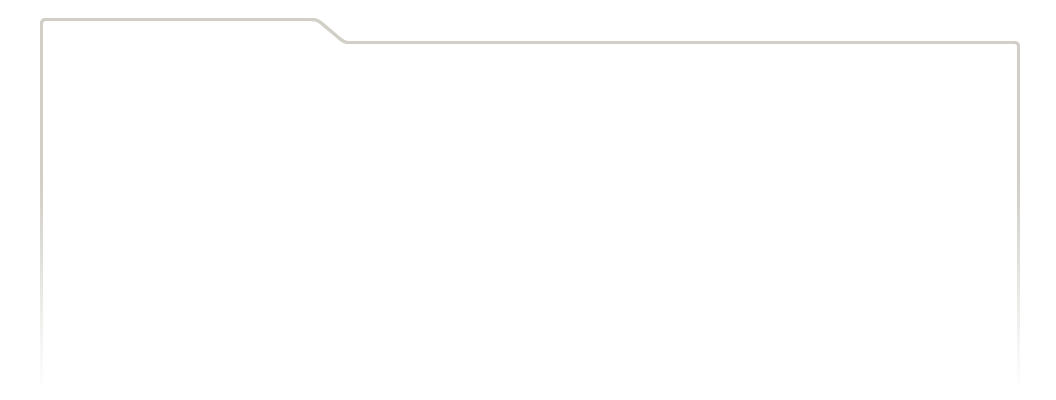
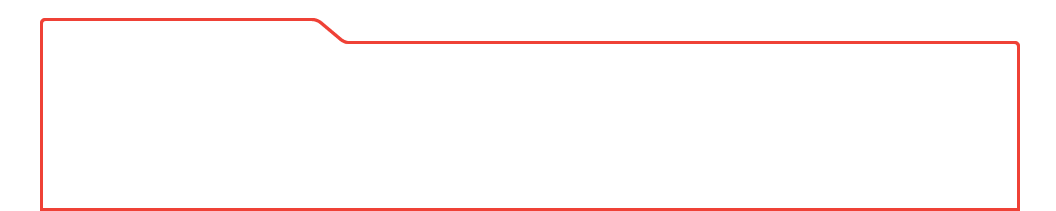
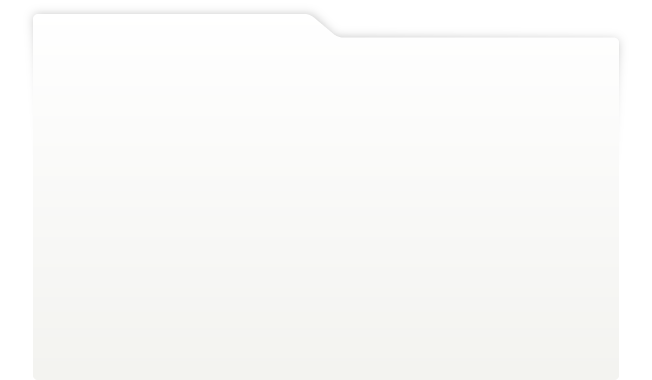
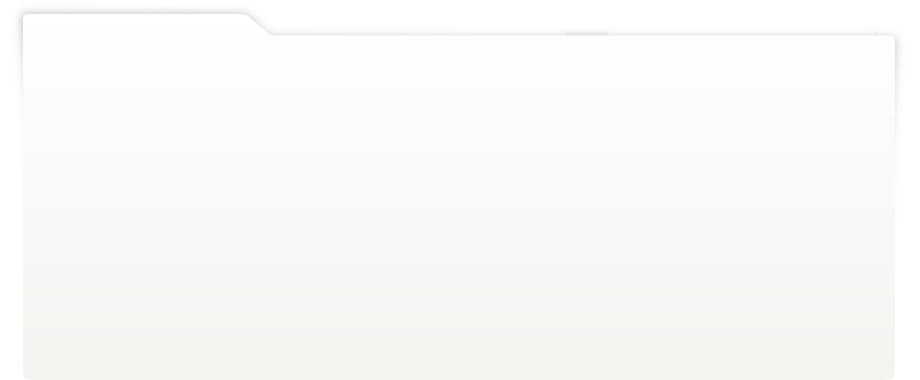
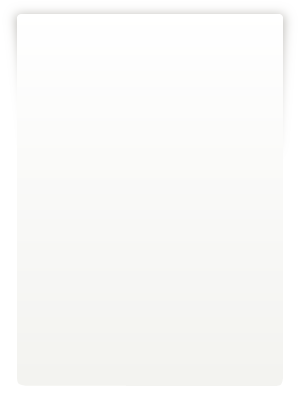
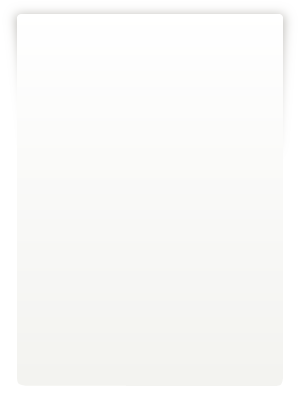
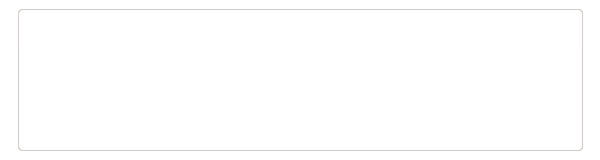
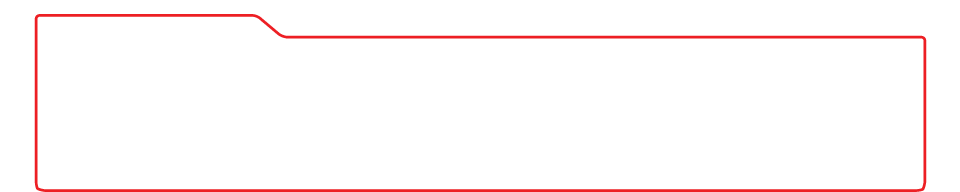
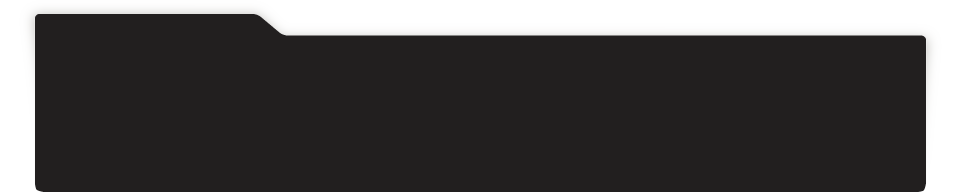
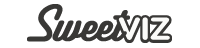
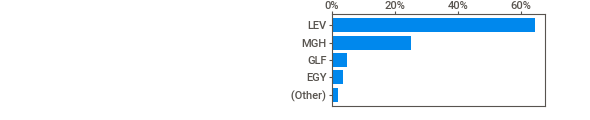
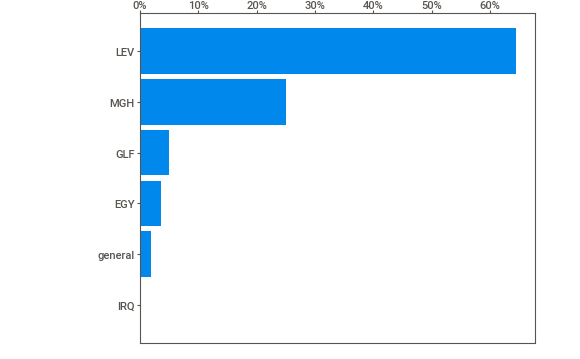
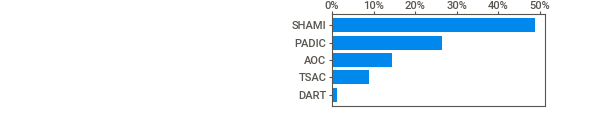
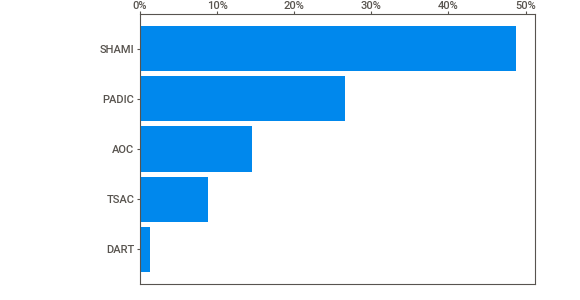
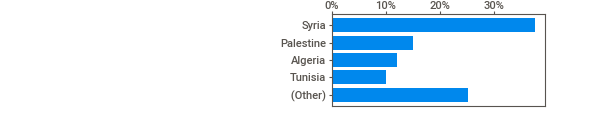
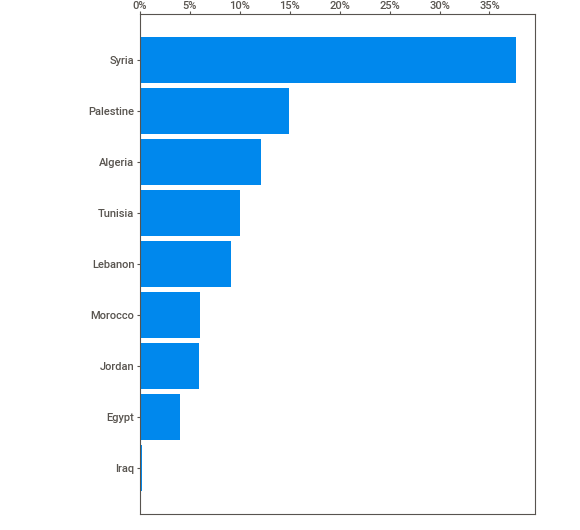
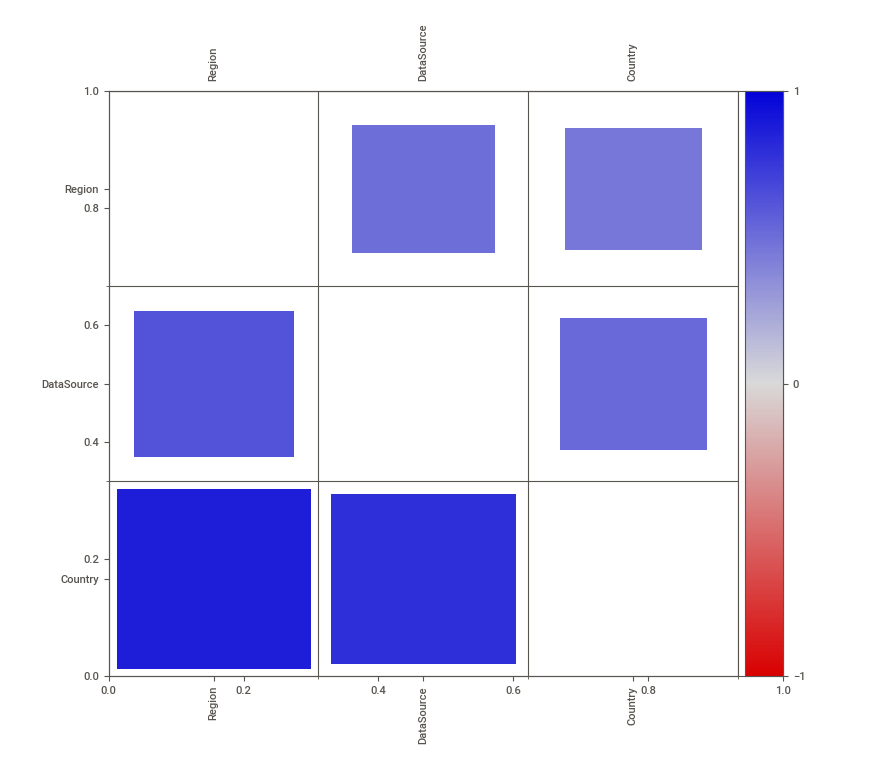
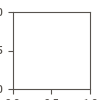

In [6]:
# EDA using sweetviz

import sweetviz as sv

report = sv.analyze(df)
report.show_html('initial_report.html')

import IPython
IPython.display.HTML(filename='/content/initial_report.html')

In [ ]:
df = df.drop(['Region', 'DataSource'], axis=1)

In [ ]:
df

,Sentence,Country
0,: وش فيك تسألني إذا كنت غالي؟ غالي وتسوى من ...,NaN
1,روان بن حسين مستحيل ما ادز شي بسناب حتى لو ما...,NaN
2,: ما نسيتك بالدعا والأرض جفاف، وشلون أبنساك و...,NaN
3,: فارس_البقميk_محب أطيب من الطيب واصل الطيب ...,NaN
4,شوفو والله ابوها كشخه وصغير احس واضحه الفلوس م...,NaN
...,...,...
135799,وترا الناس تغيرت ولايهم نظرة المجتمع مادام الو...,NaN
135800,متأثر ياربيع بالكرتون,NaN
135801,مبروك للاتحاد والاهلي وهاردلك للباقين,NaN
135802,هههههههوووووووووووووووووووووووهههههااااااااااا...,NaN


In [ ]:
# remove missing values and show count

df.dropna(inplace=True)

df.isnull().sum()

,0
Sentence,0
Country,0


In [ ]:
# remove duplicates keeping the first one and show count

df.drop_duplicates(subset=None, keep='first', inplace=True)

df.duplicated().sum()

0

In [ ]:
df = df.rename(columns={'Sentence': 'sentence', 'Country': 'country'})

In [ ]:
# Label encoding

le_x  = LabelEncoder()

df['label'] = le_x.fit_transform(df.country)

label_mapping = dict(zip(le_x.classes_, le_x.transform(le_x.classes_)))
print(label_mapping)

{'Algeria': 0, 'Egypt': 1, 'Iraq': 2, 'Jordan': 3, 'Lebanon': 4, 'Morocco': 5, 'Palestine': 6, 'Syria': 7, 'Tunisia': 8}


                                             |          | [  0%]   00:00 -> (? left)

Report final_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



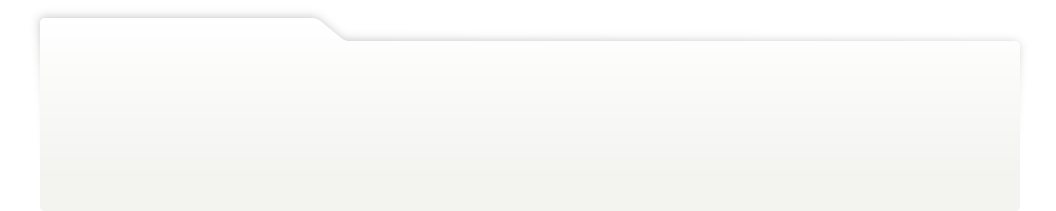
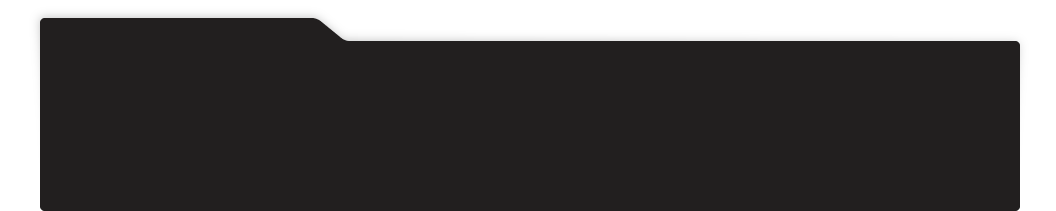
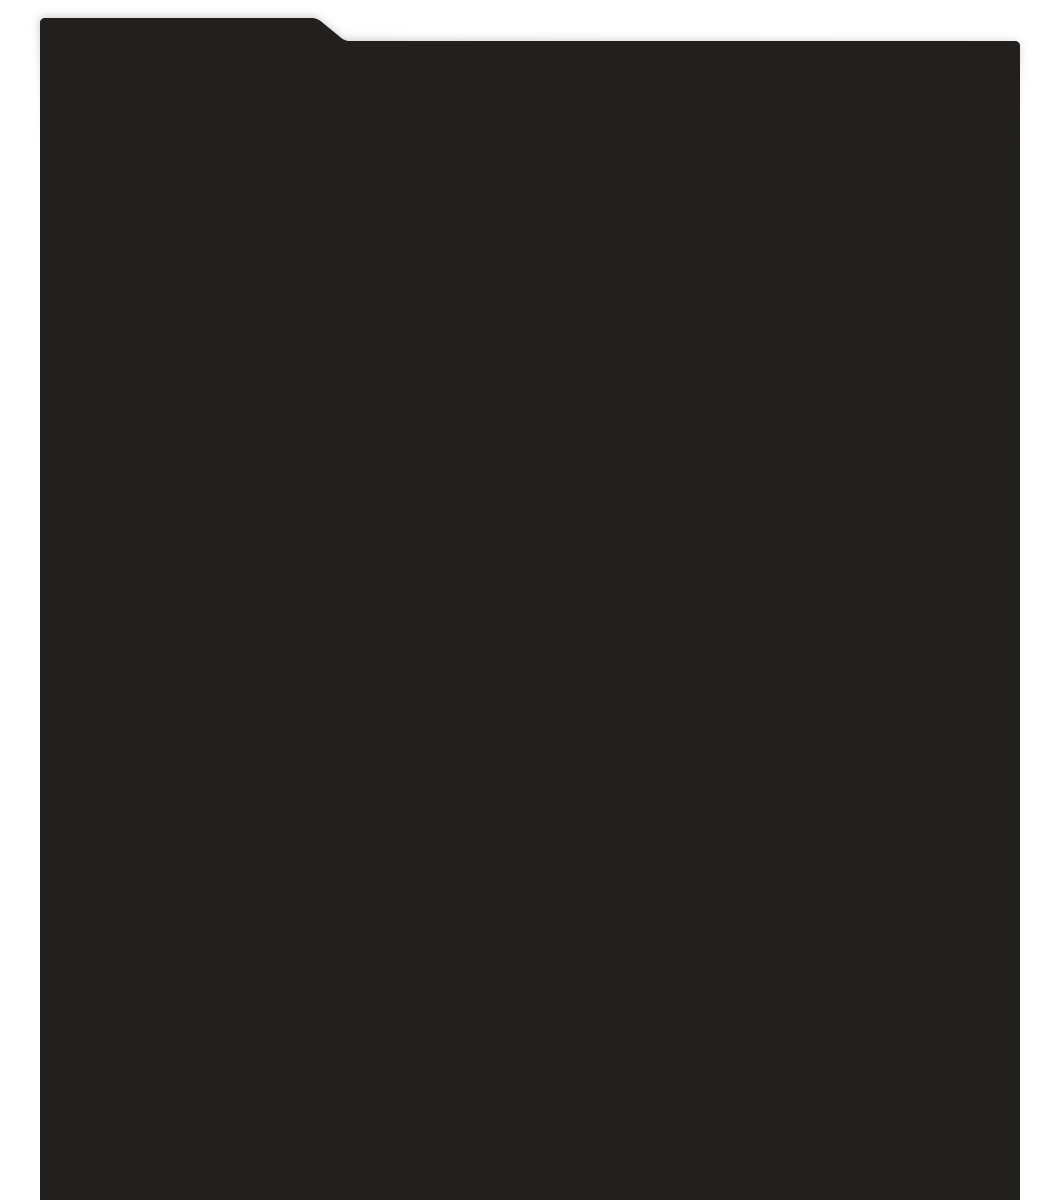
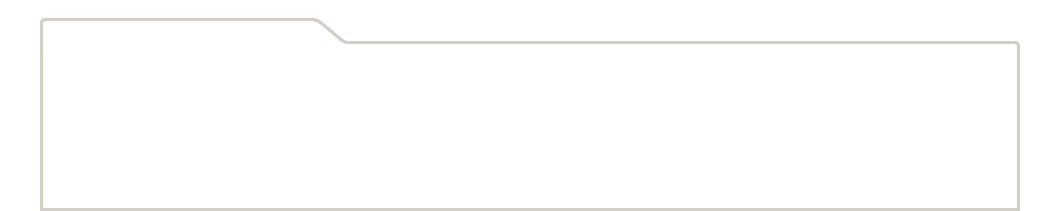
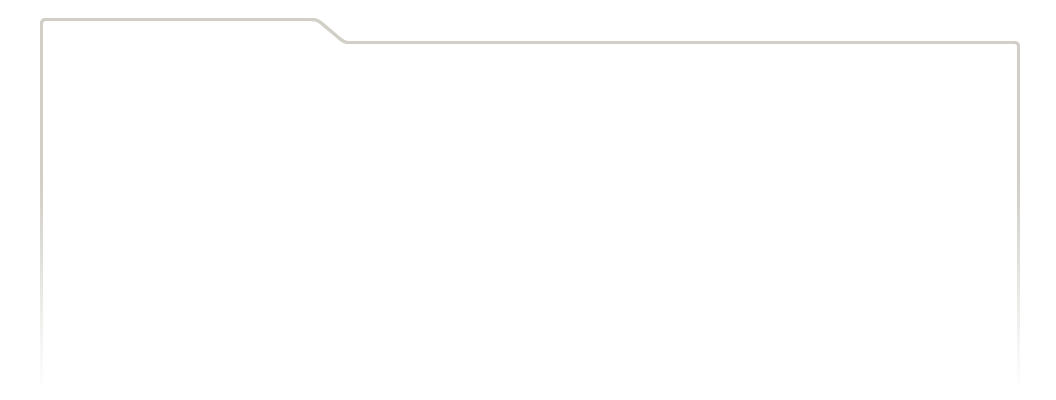
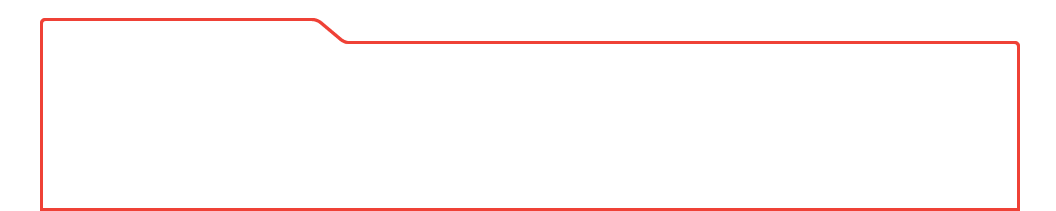
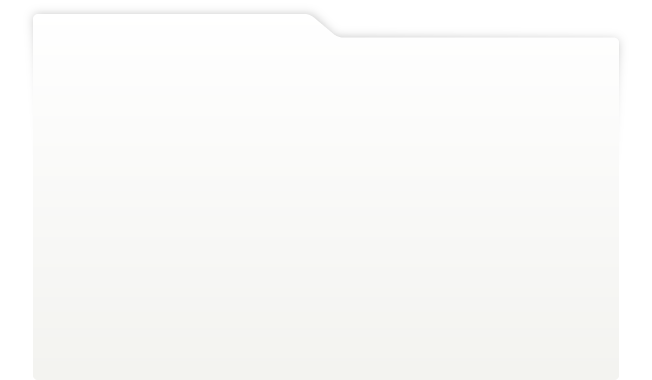
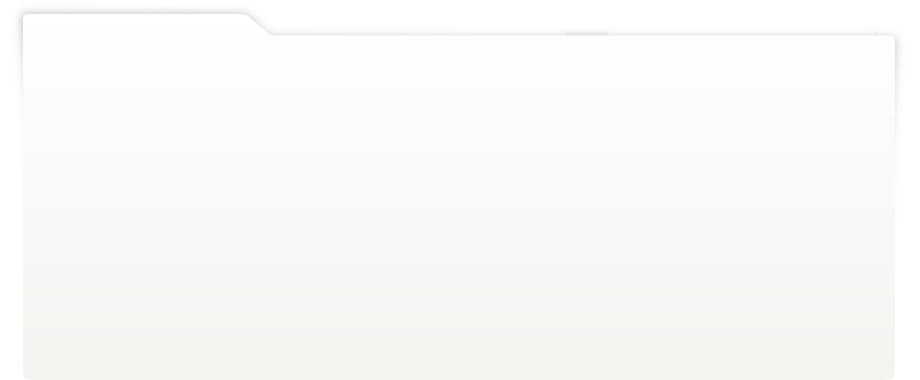
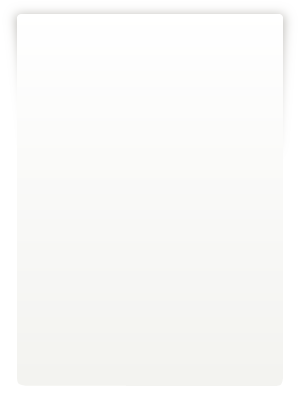
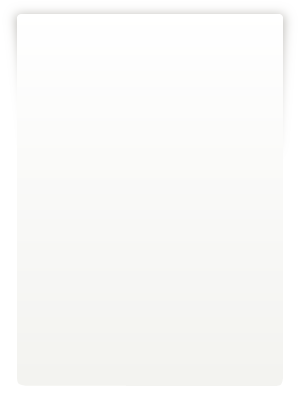
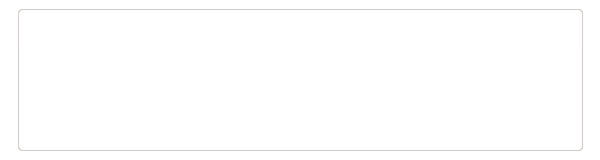
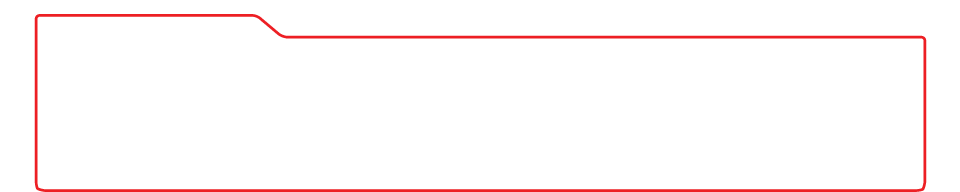
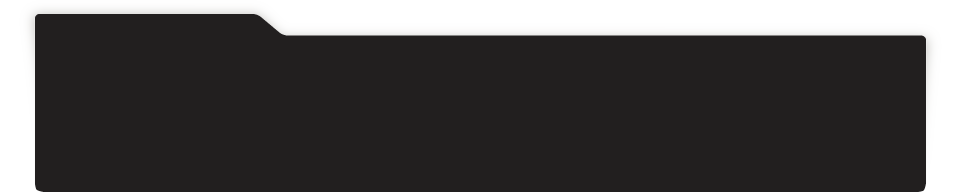
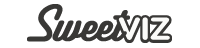
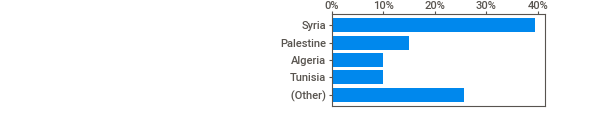
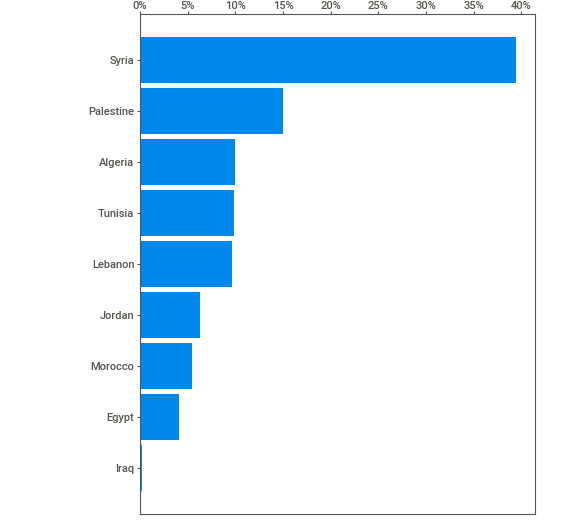
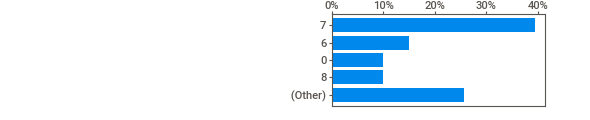
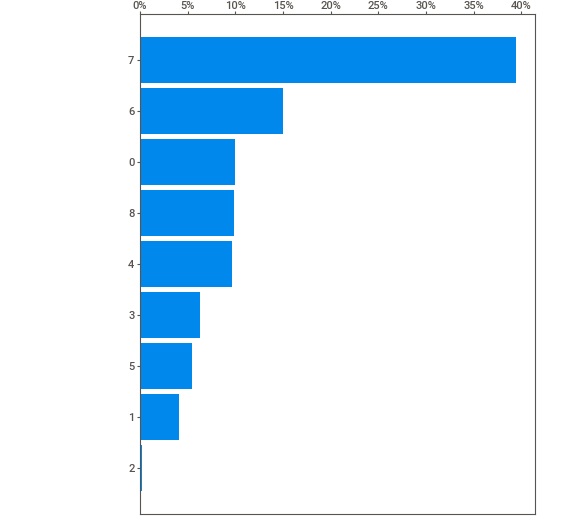
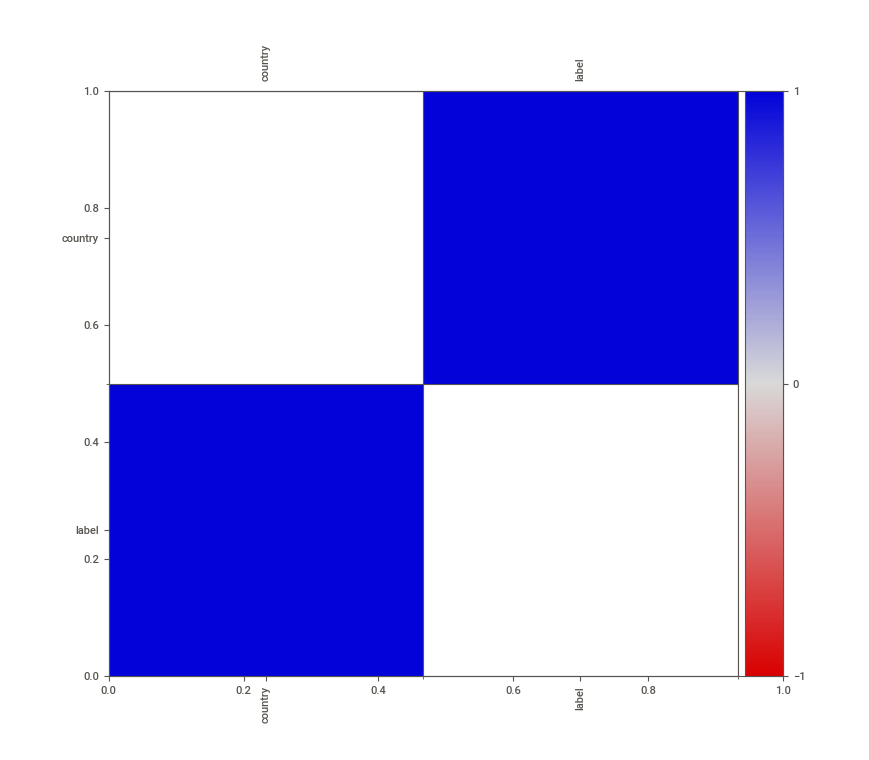
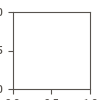

In [ ]:
report = sv.analyze(df)
report.show_html('final_report.html')

import IPython
IPython.display.HTML(filename='/content/final_report.html')

In [ ]:
df

,sentence,country,label
1151,هه اصلا حاليا فى وفد قطري موجود بغزه واللعبه ...,Palestine,6
1152,عادي طعميها لأنها ما راح تكتفي من صدرك صار بد...,Palestine,6
1153,اعملي اللي عليكي لوجه الله,Palestine,6
1154,حكت شفتها اكتر من مره بلبس قصير واكيد زوجي شا...,Palestine,6
1155,و هيا وإياه بتزوجو هه,Palestine,6
...,...,...,...
120537,هالحين تقولون انه شيعي غير متكافي النسب.. ومره...,Iraq,2
120538,خوش المواطن بحاجة لهذا القرار,Iraq,2
120539,ويمكن يشيلون كل سيارة (نص ونص) ويتركون السيارا...,Iraq,2
120540,عفكرة كل فترة بتمر طيارة وبتكون قريبة ، كانت ت...,Iraq,2


In [ ]:
# remove unnecessary symbols

def preprocess_text(text):
    punctuation_chars = "?,।!;:"
    text = ''.join(char for char in text if char not in punctuation_chars)
    text = re.sub(r"[^\w\s]", "", text)
    text = " ".join(text.split())
    return text

X_processed = df['sentence'].apply(preprocess_text)

In [ ]:
# vectorization

vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X_processed)

X_vectorized = X_vectorized.toarray()
y = df['label']

In [ ]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.8, stratify=y)

## Sampling Techniques - ERROR


‼️ NOT BEING ABLE TO PROCESS THE WHOLE DATA, DUE TO RAM SHORTAGE. SPLITING OF 0.8 IS ONLY WORKING




### Helping functions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# helper function to visualize label distribution
def plot_label_distribution(y, title):
    label_to_country = {
        0: 'Algeria',
        1: 'Egypt',
        2: 'Iraq',
        3: 'Jordan',
        4: 'Lebanon',
        5: 'Morocco',
        6: 'Palestine',
        7: 'Syria',
        8: 'Tunisia'
    }

    label_counts = pd.Series(y).value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

    for bar, count in zip(bar_plot.patches, label_counts.values):
        bar_plot.annotate(format(count, 'd'),
                          (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                          ha='center', va='bottom', fontsize=10)

    bar_plot.set_xticklabels([label_to_country[label] for label in label_counts.index], rotation=45)

    plt.title(title, fontsize=14)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


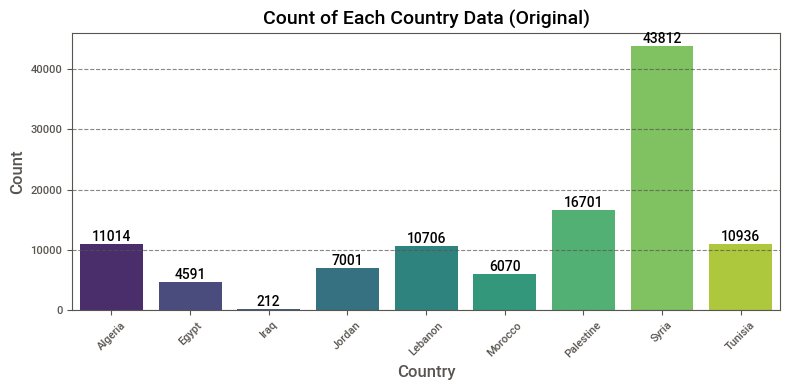

In [ ]:
# raw data
plot_label_distribution(y, title="Count of Each Country Data (Original)")

### Oversampling

#### ROS

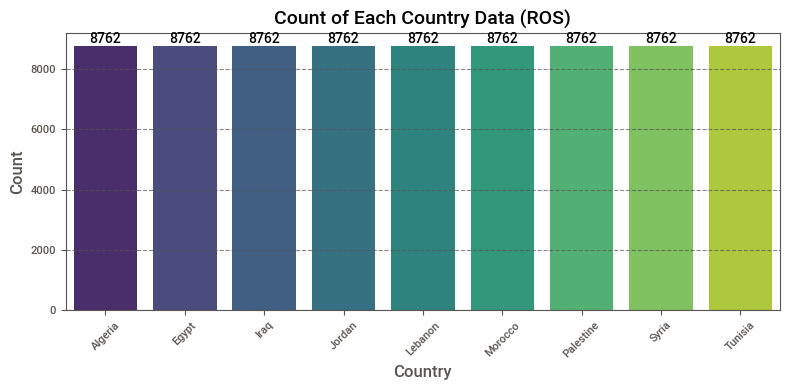

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

plot_label_distribution(y_ros, title="Count of Each Country Data (ROS)")

#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

plot_label_distribution(y_smote, title="Count of Each Country Data (SMOTE)")

#### ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

plot_label_distribution(y_adasyn, title="Count of Each Country Data (ADASYN)")

### Undersampling

#### RUS

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = ros.fit_resample(X_train, y_train)

plot_label_distribution(y_ros, title="Count of Each Country Data (RUS)")

#### Tomek Links

In [ ]:
from imblearn.under_sampling import TomekLinks

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)

plot_label_distribution(y_tl, title="Count of Each Country Data (TomekLinks)")

#### NearMiss

In [ ]:
from imblearn.under_sampling import NearMiss

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_train, y_train)

plot_label_distribution(y_nm, title="Count of Each Country Data (NearMiss)")

### Combined Techniques

#### ROS - RUS

In [ ]:
# median value as the target size
desired_class_size = int(y_train.value_counts().median())

desired_class_size

10706

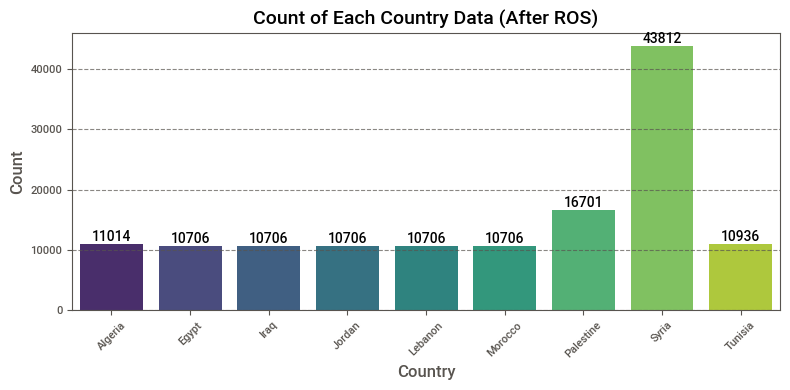

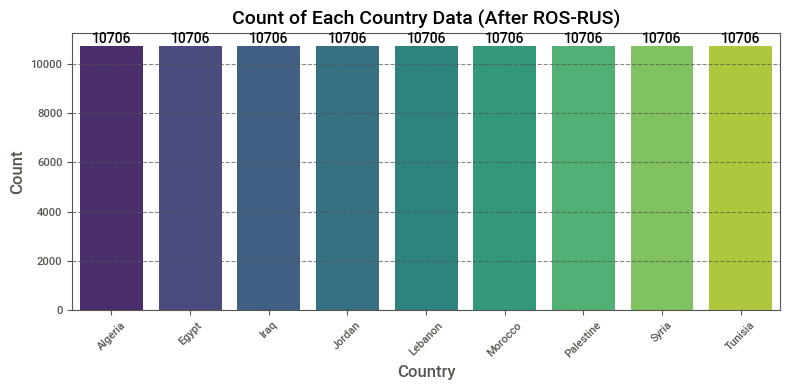

In [ ]:
# Random Oversampling
oversample = RandomOverSampler(
    sampling_strategy={1: desired_class_size, 2: desired_class_size, 3: desired_class_size, 5: desired_class_size},
    random_state=42)
X_oversampled, y_oversampled = oversample.fit_resample(X_train, y_train)

plot_label_distribution(y_oversampled, title="Count of Each Country Data (After ROS)")

# Random Undersampling
undersample = RandomUnderSampler(
    sampling_strategy={0: desired_class_size, 6: desired_class_size, 7: desired_class_size, 8: desired_class_size},
    random_state=42)
X_ros_rus, y_ros_rus = undersample.fit_resample(X_oversampled, y_oversampled)

plot_label_distribution(y_ros_rus, title="Count of Each Country Data (After ROS-RUS)")

#### SMOTEENN

In [ ]:
from imblearn.combine import SMOTEENN

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X_train, y_train)

plot_label_distribution(y_sme, title="Count of Each Country Data (SMOTEENN)")

#### SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek

# TODO: HAVE TO USE AN EFFECTIVE sampling_strategy | default is used below
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

plot_label_distribution(y_smt, title="Count of Each Country Data (SMOTETomek)")

## Dataloader Setup

In [ ]:
# dataloader setup

class DialectDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item


def prepare_data(train_data, test_data, train_label, test_label, tokenizer, batch_size):
    X_train = train_data
    X_test = test_data
    y_train = train_label
    y_test = test_label

    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

    train_dataset = DialectDataset(train_encodings, list(y_train))
    val_dataset = DialectDataset(val_encodings, list(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# checkpoint saving with time tracking
def save_checkpoint(model, optimizer, epoch, metrics, total_time, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'metrics': metrics,
        'total_time': total_time
    }

    base_dir = "/content/drive/MyDrive/Dialect/checkpoints"
    os.makedirs(base_dir, exist_ok=True)
    torch.save(checkpoint, filename)

    print(f"Checkpoint saved at epoch {epoch}. Total time so far: {total_time:.2f} minutes.")


# checkpoint loading with time tracking
def load_checkpoint(model, optimizer, filename):
    if torch.cuda.is_available():
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load(filename, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    metrics = checkpoint['metrics']
    total_time = checkpoint['total_time']

    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}. Total time so far: {total_time:.2f} minutes.")
    return model, optimizer, start_epoch, metrics, total_time


In [ ]:
# Train function
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()

    for batch in tqdm(train_loader, desc='Training'):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    train_time = (end_time - start_time) / 60
    return avg_loss, train_time


# function to calculate PF score based on presion-f1_score (harmonic mean)
def pf_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    pf = 2 * (precision * f1) / (precision + f1) if (precision + f1) != 0 else 0
    return pf


# Evaluate function
def evaluate(model, val_loader, device):
    model.eval()
    preds, labels, probs = [], [], []
    total_loss = 0
    start_time = time.time()

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            loss = outputs.loss
            total_loss += loss.item()

            probs.extend(torch.softmax(logits, dim=1).cpu().numpy())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch['labels'].tolist())

    end_time = time.time()
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    g_mean = geometric_mean_score(labels, preds, average='weighted')
    auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    balanced_acc = balanced_accuracy_score(labels, preds)
    balanced_acc_loss = 1 - balanced_accuracy_score(labels, preds)
    pf = pf_score(labels, preds)
    val_time = (end_time - start_time) / 60

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1': f1,
        'g_mean': g_mean,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'balanced_acc': balanced_acc,
        'balanced_acc_loss': balanced_acc_loss,
        'pf': pf
    }

    return metrics, val_time


In [ ]:
# Main function to test each model
def test_model(train_data, test_data, train_label, test_label, model, tokenizer, epochs, batch_size, checkpoint_path):
    train_loader, val_loader = prepare_data(train_data, test_data, train_label, test_label, tokenizer, batch_size)

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    start_epoch = 1
    metrics = None
    total_time = 0

    # Check if checkpoint exists
    try:
        model, optimizer, start_epoch, metrics, total_time = load_checkpoint(model, optimizer, filename=checkpoint_path)
    except FileNotFoundError:
        print("No checkpoint found. Starting from scratch.")

    print(f"\nModel will be trained on: {device}")

    for epoch in range(start_epoch, epochs + 1):
        print(f'\n------ Epoch {epoch}/{epochs}')

        train_loss, train_time = train(model, train_loader, optimizer, device)
        metrics, val_time = evaluate(model, val_loader, device)

        # Update total time
        total_time += train_time + val_time

        print(f'Train Loss: {train_loss:.3f}')
        for key, value in metrics.items():
            print(f'Validation {key.capitalize()}: {value:.3f}')

        # Save checkpoint
        save_checkpoint(model, optimizer, epoch, metrics, total_time, filename=checkpoint_path)

    print(f"Training & Validation completed. Total time: {total_time:.2f} minutes.")
    return model


# Model Performance

Performance will be categorized in 2 main categories.
1. W/O Sampling
2. W Samplng

In `W Sampling` - 3 oversampling, 3 undersampling and 3 combined techniques will be used.

Total - 10 outputs from each model

## XLM-Roberta

In [ ]:
# XLM-Roberta
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

xlm_roberta_base = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_raw.pth"

xlm_raw = test_model(X_train, X_test, y_train, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# random oversampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_ros.pth"

xlm_ros = test_model(X_ros, X_test, y_ros, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# smote - oversampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_smote.pth"

xlm_smote = test_model(X_smote, X_test, y_smote, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# adasyn - oversampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_adasyn.pth"

xlm_adasyn = test_model(X_adasyn, X_test, y_adasyn, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# random undersampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_rus.pth"

xlm_rus = test_model(X_rus, X_test, y_rus, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# tomek Links - undersampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_tl.pth"

xlm_tl = test_model(X_tl, X_test, y_tl, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# NearMiss - undersampling

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_nm.pth"

xlm_nm = test_model(X_nm, X_test, y_nm, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# Combined ROS - RUS

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_ros_rus.pth"

xlm_ros_rus = test_model(X_ros_rus, X_test, y_ros_rus, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# Combined SMOTEENN

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_sme.pth"

xlm_sme = test_model(X_sme, X_test, y_sme, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

In [ ]:
# Combined SMOTETomek

path = f"/content/drive/MyDrive/Dialect/checkpoints/xlm_roberta_smt.pth"

xlm_smt = test_model(X_smt, X_test, y_smt, y_test, xlm_roberta_base, xlm_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

## Arabic-BERT

In [ ]:
# Arabic-BERT
from transformers import AutoModelForSequenceClassification, AutoTokenizer

arabic_tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

arabic_bert_v2 = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv2', num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/arabic_raw.pth"

arabic_raw = test_model(X_train, X_test, y_train, y_test, arabic_bert_v2, arabic_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

## AraElectra-BERT

In [ ]:
# AraElectra-BERT
from transformers import AutoModelForSequenceClassification, AutoTokenizer

araelectra_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/araelectra-base-discriminator")

araelectra_model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/araelectra-base-discriminator", num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/ara_electra_raw.pth"

ara_raw = test_model(X_train, X_test, y_train, y_test, araelectra_model, araelectra_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

## QARIB-BERT

In [ ]:
# QARIB-BERT
from transformers import AutoModelForSequenceClassification, AutoTokenizer

qarib_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-qarib")

qarib_model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-qarib", num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/qarib_raw.pth"

qarib_raw = test_model(X_train, X_test, y_train, y_test, qarib_model, qarib_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

## mBERT

In [ ]:
# mBERT
from transformers import BertTokenizer, BertForSequenceClassification

mb_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

mb_bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/mbert_raw.pth"

mbert_raw = test_model(X_train, X_test, y_train, y_test, mb_bert, mb_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)

## Distil-BERT-Multilingual

In [ ]:
# Distil-BERT-Multilingual
from transformers import AutoModelForSequenceClassification, AutoTokenizer

distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=9)

In [ ]:
# raw data

path = f"/content/drive/MyDrive/Dialect/checkpoints/distill_bert_raw.pth"

distill_bert_raw = test_model(X_train, X_test, y_train, y_test, distilbert_model, distilbert_tokenizer, epochs=5, batch_size=64, checkpoint_path=path)